## Basic analysis

In [1]:
#Libraries and main variables initialized
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import urllib.request, json
import os
import re
import nglview as nv
from funcs import get_files_from_git
from funcs import view_nucl


import matplotlib.pyplot as plt

import MDAnalysis.analysis.pca as pca
import MDAnalysis.analysis.encore as encore

from seq_tools.plot4seq import plot_prof4seq
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import seq1
from seq_tools.hist_ss import get_hist_ss_in_aln_for_shade
import numpy as np
import xvg_plot as xvg
import xpm_plot as xpm

#Reloading funcs if changed
from importlib import reload 
import funcs,config
reload(funcs)
reload(config)


%matplotlib inline
%load_ext rpy2.ipython

from config import movtitle
from IPython.display import Markdown, display
from config import folder,descr,pname,scuser
display(Markdown(descr))
print("Folder set to: ",folder)
print("Project name: ",pname)
print("User set to:",scuser)




# MD simulations of H3-H4, tails truncated
- AMBER14SB force field
- 50 mM NaCl
- box 2nm


Folder set to:  h3-h4_tm
Project name:  h3-h4_tm
User set to: shaytan_1609


## Let's preview

In [ ]:
view_nucl('GMX_system/prot_ref.pdb', 'big_data/prot_md.xtc')


## Movie

In [3]:
#args 1 1 will trigger generation of images for movie in tmp/dat
!rm tmp/dat/*
!vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/prot_ref.pdb big_data/prot_md.xtc "$movtitle" 1 1 1 1
!rm big_data/movie.*
!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie.mov
#!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie.wmv

/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 40 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA 
Info) Free system memory: 53GB (84%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1050 Ti  6 SM_6.1 @ 1.39 GHz, 3.9GB RAM, KTO, AE2, ZCP
Info) Detected 1 available TachyonL/OptiX

Info) Tachyon: preprocessing time 0.032636 sec, render time 0.304862 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/24.dat.tga' ...
Info) Tachyon: preprocessing time 0.031644 sec, render time 0.283952 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/25.dat.tga' ...
Info) Tachyon: preprocessing time 0.031538 sec, render time 0.289038 sec.ess:  78% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/26.dat.tga' ...
Info) Tachyon: preprocessing time 0.032370 sec, render time 0.295143 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/27.dat.tga' ...
Info) Tachyon: preprocessing time 0.042615 sec, render time 0.295058 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/28.dat.t

Info) Tachyon: preprocessing time 0.031768 sec, render time 0.286550 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/65.dat.tga' ...
Info) Tachyon: preprocessing time 0.032697 sec, render time 0.304884 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/66.dat.tga' ...
Info) Tachyon: preprocessing time 0.032907 sec, render time 0.302343 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/67.dat.tga' ...
Info) Tachyon: preprocessing time 0.032649 sec, render time 0.311574 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/68.dat.tga' ...
Info) Tachyon: preprocessing time 0.032902 sec, render time 0.309190 sec.gress:   4% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/69.dat

Info) Tachyon: preprocessing time 0.033125 sec, render time 0.304804 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/105.dat.tga' ...
Info) Tachyon: preprocessing time 0.032033 sec, render time 0.285609 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/106.dat.tga' ...
Info) Tachyon: preprocessing time 0.038629 sec, render time 0.302466 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/107.dat.tga' ...
Info) Tachyon: preprocessing time 0.032474 sec, render time 0.285272 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/108.dat.tga' ...
Info) Tachyon: preprocessing time 0.033976 sec, render time 0.304723 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/109.dat.tga' ...
Info) Tachyon: 

Info) Tachyon: preprocessing time 0.033182 sec, render time 0.294784 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/144.dat.tga' ...
Info) Tachyon: preprocessing time 0.033032 sec, render time 0.294938 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/145.dat.tga' ...
Info) Tachyon: preprocessing time 0.033285 sec, render time 0.320319 sec.gress:   2% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/146.dat.tga' ...
Info) Tachyon: preprocessing time 0.032413 sec, render time 0.285886 sec.gress:   4% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/147.dat.tga' ...
Info) Tachyon: preprocessing time 0.032803 sec, render time 0.299656 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Renderin

Info) Tachyon: preprocessing time 0.033036 sec, render time 0.285833 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/183.dat.tga' ...
Info) Tachyon: preprocessing time 0.033147 sec, render time 0.287992 sec.gress:   2% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/184.dat.tga' ...
Info) Tachyon: preprocessing time 0.033081 sec, render time 0.302818 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/185.dat.tga' ...
Info) Tachyon: preprocessing time 0.032273 sec, render time 0.286420 sec.gress:   4% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/186.dat.tga' ...
Info) Tachyon: preprocessing time 0.032415 sec, render time 0.295024 sec.gress:   4% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rend

Info) Tachyon: preprocessing time 0.033300 sec, render time 0.307067 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/221.dat.tga' ...
Info) Tachyon: preprocessing time 0.033038 sec, render time 0.293204 sec.gress:   4% complete          ndering progress:  33% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/222.dat.tga' ...
Info) Tachyon: preprocessing time 0.037238 sec, render time 0.295885 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/223.dat.tga' ...
Info) Tachyon: preprocessing time 0.035804 sec, render time 0.287374 sec.gress:   2% complete          ering progress:  30% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/224.dat.tga' ...
Info) Tachyon: preprocessing time 0.032843 sec, render time 0.287579 sec

Info) Tachyon: preprocessing time 0.032862 sec, render time 0.292323 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/257.dat.tga' ...
Info) Tachyon: preprocessing time 0.041833 sec, render time 0.325132 sec.ess:  52% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/258.dat.tga' ...
Info) Tachyon: preprocessing time 0.033392 sec, render time 0.286414 sec.gress:   4% complete          hyon) Rendering progress:  57% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/259.dat.tga' ...
Info) Tachyon: preprocessing time 0.032573 sec, render time 0.285664 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/260.dat.tga' ...
Info) Tachyon: preprocessing time 0.032681 sec, render time 0.282886 sec.gress:   4% complete          
T

Info) Rendering current scene to 'tmp/dat/291.dat.tga' ...
Info) Tachyon: preprocessing time 0.034369 sec, render time 0.318665 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/292.dat.tga' ...
Info) Tachyon: preprocessing time 0.034499 sec, render time 0.361566 sec.
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/293.dat.tga' ...
Info) Tachyon: preprocessing time 0.032731 sec, render time 0.291700 sec.ess:   4% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/294.dat.tga' ...
Info) Tachyon: preprocessing time 0.033576 sec, render time 0.291666 sec.ess:   6% complete          ) Rendering progress:  16% complete          ndering progress:  26% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/295.dat.tga' ...
Info) Tachy

Info) Tachyon: preprocessing time 0.033014 sec, render time 0.315723 sec.s:   7% complete          Rendering progress:  14% complete          ering progress:  24% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/326.dat.tga' ...
Info) Tachyon: preprocessing time 0.033704 sec, render time 0.293976 sec.ess:  46% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/327.dat.tga' ...
Info) Tachyon: preprocessing time 0.033688 sec, render time 0.290177 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/328.dat.tga' ...
Info) Tachyon: preprocessing time 0.033494 sec, render time 0.304750 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/329.dat.tga' ...
Info) Tachyon: preprocessing time 0.033973 sec, render time 0.298968 sec.gre

Info) Tachyon: preprocessing time 0.033157 sec, render time 0.284822 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/357.dat.tga' ...
Info) Tachyon: preprocessing time 0.033730 sec, render time 0.307216 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/358.dat.tga' ...
Info) Tachyon: preprocessing time 0.033797 sec, render time 0.308538 sec.gress:   3% complete          on) Rendering progress:  10% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/359.dat.tga' ...
Info) Tachyon: preprocessing time 0.033663 sec, render time 0.305305 sec.gress:  73% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/360.dat.tga' ...
Info) Tachyon: preprocessing time 0.034755 sec, render time 0.307376 sec.
Total Tachyon rendering time: 0

Info) Tachyon: preprocessing time 0.034373 sec, render time 0.313693 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/390.dat.tga' ...
Info) Tachyon: preprocessing time 0.034637 sec, render time 0.308089 sec.ess:   7% complete          ) Rendering progress:  21% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/391.dat.tga' ...
Info) Tachyon: preprocessing time 0.033128 sec, render time 0.294123 sec.gress:   2% complete          on) Rendering progress:  10% complete          Rendering progress:  26% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/392.dat.tga' ...
Info) Tachyon: preprocessing time 0.033964 sec, render time 0.297281 sec.gress:   2% complete          on) Rendering progress:   6% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
I

Info) Tachyon: preprocessing time 0.033884 sec, render time 0.293953 sec.ess:  13% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/422.dat.tga' ...
Info) Tachyon: preprocessing time 0.034655 sec, render time 0.320755 sec.ess:  25% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/423.dat.tga' ...
Info) Tachyon: preprocessing time 0.033606 sec, render time 0.291009 sec.ess:  28% complete          ) Rendering progress:  38% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/424.dat.tga' ...
Info) Tachyon: preprocessing time 0.039720 sec, render time 0.306790 sec.gress:   2% complete          on) Rendering progress:   6% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/425.dat.tga' ...
Info) 

Info) Rendering current scene to 'tmp/dat/453.dat.tga' ...
Info) Tachyon: preprocessing time 0.033362 sec, render time 0.285277 sec.ess:  32% complete          hyon) Rendering progress:  76% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/454.dat.tga' ...
Info) Tachyon: preprocessing time 0.034100 sec, render time 0.325408 sec.gress:   7% complete          on) Rendering progress:  20% complete          Rendering progress:  34% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/455.dat.tga' ...
Info) Tachyon: preprocessing time 0.039146 sec, render time 0.315283 sec.ess:  13% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/456.dat.tga' ...
Info) Tachyon: preprocessing time 0.034253 sec, render time 0.343623 sec.gress:   2% complete          on) Rendering progress

Info) Tachyon: preprocessing time 0.034061 sec, render time 0.310253 sec.  68% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/483.dat.tga' ...
Info) Tachyon: preprocessing time 0.034287 sec, render time 0.304055 sec.gress:   4% complete          Rendering progress:  24% complete          ering progress:  34% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/484.dat.tga' ...
Info) Tachyon: preprocessing time 0.042987 sec, render time 0.327340 sec.ess:   7% complete          ) Rendering progress:  18% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/485.dat.tga' ...
Info) Tachyon: preprocessing time 0.034189 sec, render time 0.296328 sec.gress:  56% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to

Info) Tachyon: preprocessing time 0.034382 sec, render time 0.308328 sec.ess:  53% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/512.dat.tga' ...
Info) Tachyon: preprocessing time 0.033800 sec, render time 0.325857 sec.gress:   4% complete          hyon) Rendering progress:   8% complete          ) Rendering progress:  20% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/513.dat.tga' ...
Info) Tachyon: preprocessing time 0.034126 sec, render time 0.326972 sec.gress:   2% complete          on) Rendering progress:   7% complete          Rendering progress:  14% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/514.dat.tga' ...
Info) Tachyon: preprocessing time 0.033879 sec, render time 0.316802 sec.ess:  31% complete          ) Rendering progress:  44% complete 

Info) Tachyon: preprocessing time 0.034263 sec, render time 0.306622 sec.  36% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/541.dat.tga' ...
Info) Tachyon: preprocessing time 0.033890 sec, render time 0.295345 sec.s:  17% complete          hyon) Rendering progress:  54% complete          ) Rendering progress:  63% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/542.dat.tga' ...
Info) Tachyon: preprocessing time 0.033951 sec, render time 0.293702 sec.ess:  30% complete          ) Rendering progress:  40% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/543.dat.tga' ...
Info) Tachyon: preprocessing time 0.034138 sec, render time 0.302461 sec.gress:  47% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current 

Info) Rendering current scene to 'tmp/dat/570.dat.tga' ...
Info) Tachyon: preprocessing time 0.034262 sec, render time 0.367416 sec.ess:  22% complete          ) Rendering progress:  34% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/571.dat.tga' ...
Info) Tachyon: preprocessing time 0.040446 sec, render time 0.340642 sec.ess:   7% complete          ) Rendering progress:  20% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/572.dat.tga' ...
Info) Tachyon: preprocessing time 0.034622 sec, render time 0.303516 sec.gress:  61% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/573.dat.tga' ...
Info) Tachyon: preprocessing time 0.034471 sec, render time 0.330535 sec.gress:   2% complete          on) Rendering progress:   8% complete          Rendering progress:  21%

Info) Rendering current scene to 'tmp/dat/599.dat.tga' ...
Info) Tachyon: preprocessing time 0.034377 sec, render time 0.309314 sec.ess:  26% complete          ) Rendering progress:  38% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/600.dat.tga' ...
Info) Tachyon: preprocessing time 0.033947 sec, render time 0.299199 sec.gress:   6% complete          on) Rendering progress:  15% complete          Rendering progress:  24% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/601.dat.tga' ...
Info) Tachyon: preprocessing time 0.039626 sec, render time 0.310489 sec.gress:  45% complete          on) Rendering progress:  57% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/602.dat.tga' ...
Info) Tachyon: preprocessing time 0.034376 sec, render time 0.316733 sec.gress: 

Info) Tachyon: preprocessing time 0.035152 sec, render time 0.394899 sec.ess:   6% complete          ) Rendering progress:  17% complete          g progress:  47% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/628.dat.tga' ...
Info) Tachyon: preprocessing time 0.035172 sec, render time 0.290041 sec.gress:  44% complete          on) Rendering progress:  64% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/629.dat.tga' ...
Info) Tachyon: preprocessing time 0.035656 sec, render time 0.415211 sec.gress:   4% complete          hyon) Rendering progress:   6% complete          ) Rendering progress:  19% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/630.dat.tga' ...
Info) Tachyon: preprocessing time 0.036399 sec, render time 0.328653 sec.ess:  19% complete         

Info) Rendering current scene to 'tmp/dat/654.dat.tga' ...
Info) Tachyon: preprocessing time 0.034709 sec, render time 0.297915 sec.ess:  35% complete          on) Rendering progress:  40% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/655.dat.tga' ...
Info) Tachyon: preprocessing time 0.039108 sec, render time 0.354661 sec.gress:  15% complete          on) Rendering progress:  26% complete          Rendering progress:  37% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/656.dat.tga' ...
Info) Tachyon: preprocessing time 0.035961 sec, render time 0.311142 sec.ess:  53% complete          ) Rendering progress:  63% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/657.dat.tga' ...
Info) Tachyon: preprocessing time 0.034630 sec, render time 0.291474 sec.gress:   

Info) Tachyon: preprocessing time 0.037329 sec, render time 0.364704 sec.gress:   4% complete          hyon) Rendering progress:   7% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/681.dat.tga' ...
Info) Tachyon: preprocessing time 0.034726 sec, render time 0.486615 sec.gress:   7% complete          hyon) Rendering progress:  14% complete          ) Rendering progress:  27% complete          ndering progress:  39% complete          ing progress:  53% complete          
Total Tachyon rendering time: 0.6 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/682.dat.tga' ...
Info) Tachyon: preprocessing time 0.035204 sec, render time 0.359295 sec.ess:  24% complete          ) Rendering progress:  35% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/683.dat.tga' ...
Info) Tachyon: preprocessing time 0.035208 sec, render 

Info) Tachyon: preprocessing time 0.034849 sec, render time 0.367447 sec.
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/709.dat.tga' ...
Info) Tachyon: preprocessing time 0.037278 sec, render time 0.341044 sec.gress:   3% complete          on) Rendering progress:  10% complete          Rendering progress:  28% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/710.dat.tga' ...
Info) Tachyon: preprocessing time 0.035845 sec, render time 0.461515 sec.gress:   3% complete          hyon) Rendering progress:   8% complete          ) Rendering progress:  23% complete          ndering progress:  34% complete          ing progress:  48% complete          
Total Tachyon rendering time: 0.6 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/711.dat.tga' ...
Info) Tachyon: preprocessing time 0.035636 sec, render time 0.314856 sec.ess:  29% comp

Info) Tachyon: preprocessing time 0.034714 sec, render time 0.361681 sec.s:  40% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/736.dat.tga' ...
Info) Tachyon: preprocessing time 0.040055 sec, render time 0.526723 sec.gress:   3% complete          hyon) Rendering progress:   7% complete          ) Rendering progress:  20% complete          ndering progress:  38% complete          ing progress:  50% complete          
Total Tachyon rendering time: 0.6 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/737.dat.tga' ...
Info) Tachyon: preprocessing time 0.034619 sec, render time 0.343026 sec.ess:   5% complete          ) Rendering progress:  15% complete          ndering progress:  28% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/738.dat.tga' ...
Info) Tachyon: preprocessing time 0.034814 sec, render time 0.33056

Info) Tachyon: preprocessing time 0.034834 sec, render time 0.298592 sec.gress:  51% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/763.dat.tga' ...
Info) Tachyon: preprocessing time 0.035247 sec, render time 0.494437 sec.gress:   2% complete          on) Rendering progress:   7% complete          Rendering progress:  12% complete          ering progress:  22% complete          
Total Tachyon rendering time: 0.6 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/764.dat.tga' ...
Info) Tachyon: preprocessing time 0.035181 sec, render time 0.307941 sec.gress:  32% complete          on) Rendering progress:  63% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/765.dat.tga' ...
Info) Tachyon: preprocessing time 0.035089 sec, render time 0.295970 sec.gress:   3% complete          on) Rendering progress:  11% complete   

Info) Tachyon: preprocessing time 0.035154 sec, render time 0.327828 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/791.dat.tga' ...
Info) Tachyon: preprocessing time 0.035435 sec, render time 0.305629 sec.gress:  46% complete          on) Rendering progress:  66% complete          Rendering progress:  90% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/792.dat.tga' ...
Info) Tachyon: preprocessing time 0.036605 sec, render time 0.394095 sec.gress:   3% complete          on) Rendering progress:  12% complete          ) Rendering progress:  21% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/793.dat.tga' ...
Info) Tachyon: preprocessing time 0.035745 sec, render time 0.308496 sec.gress:   2% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.

Info) Tachyon: preprocessing time 0.035579 sec, render time 0.362784 sec.s:  12% complete          Rendering progress:  25% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/818.dat.tga' ...
Info) Tachyon: preprocessing time 0.035182 sec, render time 0.461759 sec.gress:   3% complete          on) Rendering progress:  12% complete          Rendering progress:  26% complete          ering progress:  34% complete          
Total Tachyon rendering time: 0.6 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/819.dat.tga' ...
Info) Tachyon: preprocessing time 0.035297 sec, render time 0.538255 sec.ess:   6% complete          on) Rendering progress:  13% complete          Rendering progress:  25% complete          ering progress:  38% complete          g progress:  56% complete          
Total Tachyon rendering time: 0.6 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/820.da

Tachyon) Rendering 

Tachyon) Rendering progress: 

Info) Tachyon: preprocessing time 0.034552 sec, render time 0.295827 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/844.dat.tga' ...
Info) Tachyon: preprocessing time 0.035497 sec, render time 0.319811 sec.ess:   7% complete          ) Rendering progress:  16% complete          ndering progress:  30% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/845.dat.tga' ...
Info) Tachyon: preprocessing time 0.040491 sec, render time 0.340816 sec.ess:   5% complete          ) Rendering progress:  10% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/846.dat.tga' ...
Info) Tachyon: preprocessing time 0.034845 sec, render time 0.360502 sec.ess:   6% complete          on) Rendering progress:  11% complete          Rendering progress:  24% complete          
Total Tachyon rendering time: 

Info) Tachyon: preprocessing time 0.034807 sec, render time 0.403617 sec.  16% complete          ndering progress:  26% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/872.dat.tga' ...
Info) Tachyon: preprocessing time 0.035296 sec, render time 0.441932 sec.gress:   3% complete          hyon) Rendering progress:   6% complete          ) Rendering progress:  19% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/873.dat.tga' ...
Info) Tachyon: preprocessing time 0.035423 sec, render time 0.521377 sec.ess:   6% complete          on) Rendering progress:  11% complete          Rendering progress:  23% complete          ering progress:  32% complete          g progress:  42% complete          
Total Tachyon rendering time: 0.6 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/874.dat.tga' ...
Info) Tachyon: preprocessing

Info) Tachyon: preprocessing time 0.034904 sec, render time 0.313055 sec.ess:   7% complete          ndering progress:  31% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/897.dat.tga' ...
Info) Tachyon: preprocessing time 0.035012 sec, render time 0.302636 sec.ess:   6% complete          ) Rendering progress:  19% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/898.dat.tga' ...
Info) Tachyon: preprocessing time 0.035499 sec, render time 0.302430 sec.gress:  58% complete          on) Rendering progress:  69% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/899.dat.tga' ...
Info) Tachyon: preprocessing time 0.035362 sec, render time 0.342404 sec.gress:   4% complete          on) Rendering progress:  13% complete          Rendering progress:  25% complete       

Info) Tachyon: preprocessing time 0.038736 sec, render time 0.324770 sec.s:  61% complete          Rendering progress:  72% complete          ering progress:  85% complete          g progress:  96% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/923.dat.tga' ...
Info) Tachyon: preprocessing time 0.038387 sec, render time 0.342634 sec.       
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/924.dat.tga' ...
Info) Tachyon: preprocessing time 0.035587 sec, render time 0.385476 sec.gress:   3% complete          hyon) Rendering progress:   6% complete          ) Rendering progress:  19% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/925.dat.tga' ...
Info) Tachyon: preprocessing time 0.035132 sec, render time 0.655446 sec.ess:   6% complete          on) Rendering progress:  11% compl

Info) Tachyon: preprocessing time 0.035747 sec, render time 0.301304 sec.gress:  79% complete          on) Rendering progress:  95% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/950.dat.tga' ...
Info) Tachyon: preprocessing time 0.039226 sec, render time 0.565180 sec.ess:   6% complete          on) Rendering progress:  10% complete          Rendering progress:  24% complete          ering progress:  38% complete          g progress:  48% complete          
Total Tachyon rendering time: 0.7 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/951.dat.tga' ...
Info) Tachyon: preprocessing time 0.035664 sec, render time 0.306446 sec.gress:  54% complete          on) Rendering progress:  67% complete          Rendering progress:  81% complete          ering progress:  93% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/da

Info) Tachyon: preprocessing time 0.035276 sec, render time 0.398706 sec.ess:   6% complete          Rendering progress:  24% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/976.dat.tga' ...
Info) Tachyon: preprocessing time 0.035196 sec, render time 0.287993 sec.gress:   3% complete          achyon) Rendering progress:  77% complete          on) Rendering progress:  90% complete          
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/977.dat.tga' ...
Info) Tachyon: preprocessing time 0.036356 sec, render time 0.377588 sec.          9% complete          % complete          mplete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/978.dat.tga' ...
Info) Tachyon: preprocessing time 0.036240 sec, render time 0.398529 sec.gress:   4% complete          hyon) Rendering progress:   8% complete 

Info) Tachyon: preprocessing time 0.039229 sec, render time 0.372519 sec.ess:   6% complete          ) Rendering progress:  18% complete          ndering progress:  28% complete          ing progress:  39% complete          
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) Exiting normally.
ffmpeg version 4.0 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7.2.0 (crosstool-NG fa8859cb)
  configuration: --prefix=/opt/miniconda3/envs/moldyn --cc=/opt/conda/conda-bld/ffmpeg_1531088893642/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-shared --enable-static --enable-zlib --enable-pic --enable-gpl --enable-version3 --disable-nonfree --enable-hardcoded-tables --enable-avresample --enable-libfreetype --disable-openssl --disable-gnutls --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --disable-libx264
  libavutil      56. 14.100 / 56. 14.100
  libavcodec    

In [72]:
#Make a smooth movie
!vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/prot_ref.pdb big_data/prot_md.xtc "$movtitle, smoothed" 20 1 1 1
!rm big_data/movie_sm20.*
!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_sm20.mov
#!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_sm20.wmv

/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 40 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA 
Info) Free system memory: 51GB (80%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1050 Ti  6 SM_6.1 @ 1.39 GHz, 3.9GB RAM, KTO, AE2, ZCP
Info) Detected 1 available TachyonL/OptiX

frame=   20 fps=0.0 q=0.0 Lsize=    1076kB time=00:00:00.76 bitrate=11595.9kbits/s speed= 7.1x    
video:1075kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.084666%


In [5]:
%%HTML
<video width="320" height="240" controls>
  <source src="big_data/movie.mov" type="video/mp4">
</video>
<video width="320" height="240" controls>
  <source src="big_data/movie_sm20.mov" type="video/mp4">
</video>

## RMSD, radius of gyration

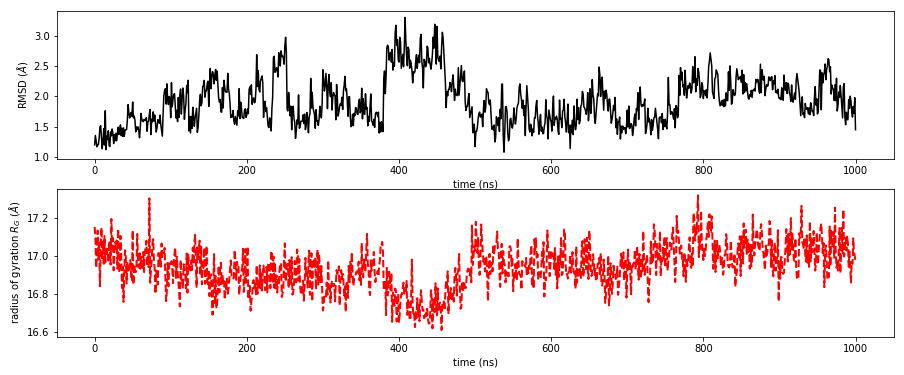

In [6]:
#MDAnalysis
trj=mda.Universe('GMX_system/prot_ref.pdb', 'big_data/prot_md.xtc')
ref = mda.Universe('GMX_system/prot_ref.pdb')
R = mda.analysis.rms.RMSD(trj, ref, select="protein and backbone",filename="big_data/rmsd.dat")
R.run()

rmsd = R.rmsd.T   # transpose makes it easier for plotting

time = list(map(lambda x: x/1000,rmsd[1]))

prot = trj.select_atoms("protein")
Rgyr=[]
for ts in trj.trajectory[::1]:
   Rgyr.append((trj.trajectory.time, prot.radius_of_gyration()))
Rgyr = np.array(Rgyr)

plt.figure(figsize=(15,6))
ax = plt.subplot(211)
ax.plot(time, rmsd[2], 'k-',  label="backbone")
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"RMSD ($\AA$)")

ax2 = plt.subplot(212)
ax2.plot(time, Rgyr[:,1], 'r--', lw=2, label=r"$R_G$")
ax2.set_xlabel("time (ns)")
ax2.set_ylabel(r"radius of gyration $R_G$ ($\AA$)")

plt.draw()

## RMSF along the sequence

In [7]:
# Let's extract the sequence
u=mda.Universe('GMX_system/prot_ref.pdb')
#prot = nuclMD.select_atoms("protein")
#u.select_atoms('segid A and protein').segments.resnames[0]
#list(u.select_atoms('segid A and protein').segments.resnames[0])
chainA_seq=seq1(''.join(list(u.select_atoms('segid A and protein').segments.resnames[0])))
chainB_seq=seq1(''.join(list(u.select_atoms('segid B and protein').segments.resnames[0])))
print(chainA_seq)
#Let's get features
msaH3=MultipleSeqAlignment([SeqRecord(Seq(chainA_seq[1:]),id='H3',name='H3')])
featuresH3=get_hist_ss_in_aln_for_shade(msaH3,below=True)
msaH4=MultipleSeqAlignment([SeqRecord(Seq(chainB_seq[1:]),id='H4',name='H4')])
featuresH4=get_hist_ss_in_aln_for_shade(msaH4,below=True)


XGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA
SingleLetterAlphabet() alignment with 2 rows and 135 columns
ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPG...ERA H3
-------------------------------------------G...ERA Query
Type detected= H3
SingleLetterAlphabet() alignment with 2 rows and 102 columns
SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVK...FGG H4
----------------------RDNIQGITKPAIRRLARRGGVK...FGG Query
Type detected= H4


In [8]:
# Let's generate RMSF for every amino acid Calpha
from MDAnalysis.analysis.rms import RMSF
trj=mda.Universe('GMX_system/prot_ref.pdb', 'big_data/prot_md.xtc')
calphasH3 = trj.select_atoms("segid A and name CA")
rmsferH3 = RMSF(calphasH3, verbose=True).run()
calphasH4 = trj.select_atoms("segid B and name CA")
rmsferH4 = RMSF(calphasH4, verbose=True).run()

Step  1001/1001 [100.0%]
Step  1001/1001 [100.0%]


### Texshade way

In [9]:

plot_prof4seq('big_data/h3-rmsf',rmsferH3.rmsf,msaH3,featuresH3,axis='RMSF, A')
plot_prof4seq('big_data/h4-rmsf',rmsferH4.rmsf,msaH4,featuresH4,axis='RMSF, A')

Chosen splitting parameters
2 20
Launcning Latex:
pdflatex --file-line-error --synctex=1 -output-directory=/tmp --save-size=10000  /tmp/align.tex > /dev/null
mv /tmp/align.pdf /tmp/tempshade.pdf
Converting PDF to PNG
convert -density 150 /tmp/tempshade.pdf -trim -bordercolor White -border 0.000%x0% /tmp/tempprofseq.png
Chosen splitting parameters
2 20
Launcning Latex:
pdflatex --file-line-error --synctex=1 -output-directory=/tmp --save-size=10000  /tmp/align.tex > /dev/null
mv /tmp/align.pdf /tmp/tempshade.pdf
Converting PDF to PNG
convert -density 150 /tmp/tempshade.pdf -trim -bordercolor White -border 0.000%x0% /tmp/tempprofseq.png


In [10]:
%%HTML
H3 C-alpha RMSF
<img src="big_data/h3-rmsf.png" alt="Plot" >
H4 C-alpha RMSF
<img src="big_data/h4-rmsf.png" alt="Plot" >

### Matplotlib way

## Side chain fluctuations
We need to make plot as above but for side chains. The charactristic now is RMSF not of position but of RMSD taken for the atoms of the side chain.

## Fluctuation heat plots
We need to make 2D heatplots showing a) C-alphas position deviation from X-ray, b) side chain RMSD, along the sequence in time.

## Cluster analysis

Gromacs way

http://manual.gromacs.org/documentation/current/onlinehelp/gmx-rms.html

http://manual.gromacs.org/documentation/current/onlinehelp/gmx-cluster.html

In [11]:
%%bash
#gromacs implementation 
gmx rms -dt 1 -tu ns -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -f2 big_data/prot_md.xtc -m big_data/rmsd-matrix.xpm -o big_data/rmsd.xvg <<!
1
1
!

Selected 1: 'Protein'
Selected 1: 'Protein'


                       :-) GROMACS - gmx rms, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS deve

In [12]:
from importlib import reload 
import xpm_plot
reload(xpm_plot)

<module 'xpm_plot' from '/home/_shared/_projects/gmx_template/xpm_plot.py'>

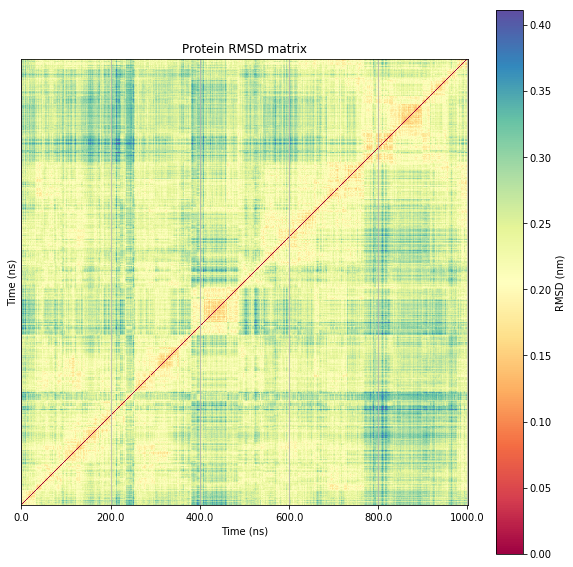

In [13]:
metadata, data = xpm.parse_xpm('big_data/rmsd-matrix.xpm')
xpm.plot_data(data, metadata)


In [14]:
%%bash
#gromacs implementation 
gmx cluster -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -dm big_data/rmsd-matrix.xpm -dt 1000 \
-dist big_data/rms-distribution.xvg -o big_data/clusters.xpm -sz big_data/cluster-sizes.xvg \
-tr big_data/cluster-transitions.xpm -ntr big_data/cluster-transitions.xvg -g big_data/cluster.log \
-clid big_data/cluster-id-over-time.xvg -cl big_data/clusters.pdb -cutoff 0.25 -method gromos <<!
1
1
!
#pymol clusters.pdb 
#split_states clusters
#delete clusters 
#dss
#show cartoon


Selected 1: 'Protein'
Selected 1: 'Protein'


                     :-) GROMACS - gmx cluster, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [15]:
view_nucl('big_data/clusters.pdb')


NGLWidget(count=8)

### Plot clustering XVG files

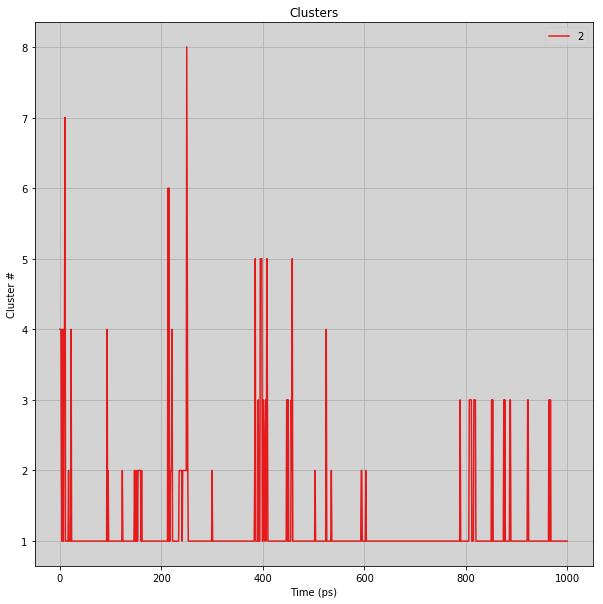

In [16]:
metadata, data = xvg.parse_xvg('big_data/cluster-id-over-time.xvg', 'all')
xvg.plot_data(data, metadata)


## PCA

## PCA analysis

http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-covar.html

In [17]:
%%bash 
#gromacs implementation
#Choose a group for the least squares fit (4 - backbone)
#Choose a group for the covariance analysis (4 - backbone)

#gmx covar -s GMX_run/7_prod.tpr -f big_data/h3-h4.xtc -o big_data/eigenval.xvg -v big_data/eigenvect.trr -xpma big_data/covara.xpm <<!
#4
#4
#!
gmx covar -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -o big_data/eigenval.xvg -v big_data/eigenvect.trr -xpma big_data/covara.xpm -av big_data/average.pdb -l big_data/covar.log <<!
7
7
!


Choose a group for the least squares fit
Selected 7: 'MainChain+H'

Choose a group for the covariance analysis
Selected 7: 'MainChain+H'


                      :-) GROMACS - gmx covar, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [18]:
#This is now done in step 1_prepare
#%%bash --out out --err err
## Let's make backbone file
#gmx trjconv -f GMX_system/init_solv_ions.pdb -s GMX_run/7_prod.tpr -o big_data/bb_xray.pdb << !
#4
#!
#gmx trjconv -f GMX_system/init_solv_ions.pdb -s GMX_run/7_prod.tpr -o big_data/bb-h_xray.pdb << !
#7
#!

In [19]:
from importlib import reload 
import xvg_plot
import xpm_plot


reload(xvg_plot)
reload(xpm_plot)

<module 'xpm_plot' from '/home/_shared/_projects/gmx_template/xpm_plot.py'>

No handles with labels found to put in legend.


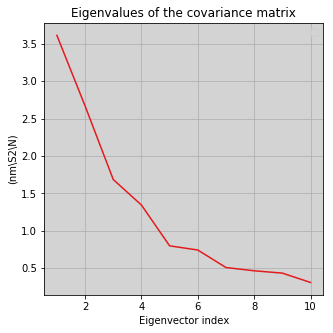

In [20]:
metadata, data = xvg.parse_xvg('big_data/eigenval.xvg', 'all')
data=np.array(data)
data=data[:,0:10]
xvg.plot_data(data, metadata,figsize=(5,5))


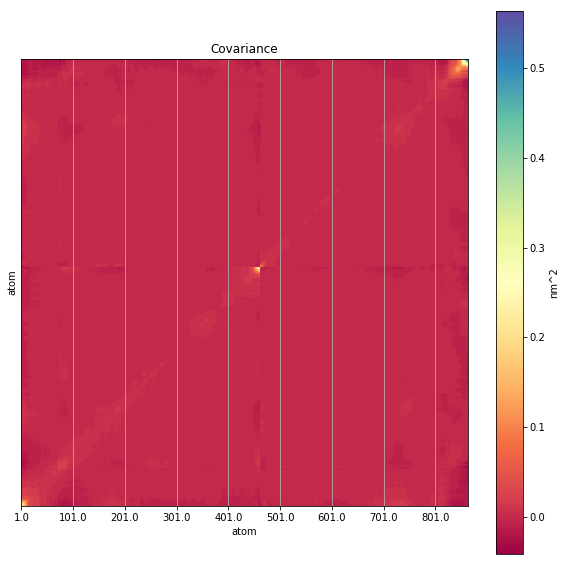

In [21]:
metadata, data = xpm.parse_xpm('big_data/covara.xpm')
xpm.plot_data(data, metadata)


### Let's filter our trajectory along one or several eigenvectors
http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-anaeig.html

In [22]:
%%bash --err err 
gmx anaeig -v big_data/eigenvect.trr -dt 10000 -s GMX_run/7_prod.tpr -f big_data/prot-MD.xtc -first 1 -last 1 -filt big_data/filtered.xtc <<!
7
7
!
# We need to center it
gmx trjconv -f big_data/filtered.xtc -s GMX_system/bb-h_ref.pdb -o big_data/filtered.xtc -fit rot+trans << !
1
1
!


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Select group for least squares fit
Selected 1: 'Protein'
Select group for output
Selected 1: 'Protein'


In [23]:
view_nucl('GMX_system/bb-h_ref.pdb','big_data/filtered.xtc')

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=101)

#### Let's make movie

In [24]:
!rm tmp/dat/*
!vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/bb-h_ref.pdb big_data/filtered.xtc "$movtitle, filtered 1 eigenvector" 1 1 1 1
!rm big_data/movie_pca_filt.*
!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_pca_filt.mov
#!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_pca_filt.wmv

/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 40 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA 
Info) Free system memory: 53GB (84%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1050 Ti  6 SM_6.1 @ 1.39 GHz, 3.9GB RAM, KTO, AE2, ZCP
Info) Detected 1 available TachyonL/OptiX

Info) Tachyon: preprocessing time 0.032299 sec, render time 0.337707 sec.
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/24.dat.tga' ...
Info) Tachyon: preprocessing time 0.032395 sec, render time 0.348676 sec.
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/25.dat.tga' ...
Info) Tachyon: preprocessing time 0.036963 sec, render time 0.335802 sec.
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/26.dat.tga' ...
Info) Tachyon: preprocessing time 0.037007 sec, render time 0.339424 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/27.dat.tga' ...
Info) Tachyon: preprocessing time 0.033229 sec, render time 0.318839 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/28.dat.tga' ...
Info) Tachyon: prepr

Info) Tachyon: preprocessing time 0.032324 sec, render time 0.334136 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/66.dat.tga' ...
Info) Tachyon: preprocessing time 0.032437 sec, render time 0.319744 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/67.dat.tga' ...
Info) Tachyon: preprocessing time 0.032188 sec, render time 0.317076 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/68.dat.tga' ...
Info) Tachyon: preprocessing time 0.031889 sec, render time 0.320770 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/69.dat.tga' ...
Info) Tachyon: preprocessing time 0.033116 sec, render time 0.328000 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/70.dat.tga' ...
Info) Tachyon: prepr

frame=  101 fps=0.0 q=0.0 Lsize=    6334kB time=00:00:04.00 bitrate=12971.4kbits/s speed= 9.4x    
video:6333kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.020665%


In [26]:
%%HTML
<video width="320" height="240" controls>
  <source src="big_data/movie_pca_filt.mov" type="video/mp4">
</video>

### Let's make interpolations for 6 PCA vectors
http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-anaeig.html

In [27]:
%%bash 
#--out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -first 1 -last 6 -nframes 50  -extr big_data/interp.xtc<<!
7
7
!

for i in `seq 1 6`; do
echo $i
gmx trjconv -f big_data/interp$i.xtc -s GMX_system/bb-h_ref.pdb -o big_data/interp$i.xtc -fit rot+trans << !
1
1
!
done


Select the index group that was used for the least squares fit in g_covar
Selected 7: 'MainChain+H'

Select an index group of 863 elements that corresponds to the eigenvectors
Selected 7: 'MainChain+H'

1

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Select group for least squares fit
Selected 1: 'Protein'
Select group for output
Selected 1: 'Protein'
2

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Select group for least squares fit
Selected 1: 'Protein'
Select group for output
Selected 1: 'Protein'
3

 

                      :-) GROMACS - gmx anaeig, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [28]:
view_nucl('GMX_system/bb-h_ref.pdb','big_data/interp1.xtc',gui=True)

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=50)

In [29]:
%%writefile tmp/render.sh
#!/bin/bash
for p in `seq 1 6`; do 
rm tmp/dat/* ;
vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/bb-h_ref.pdb big_data/interp$p.xtc "$1, PCA eigenv. $p interp" 1 1 1 0

echo "Let's add back frames" 
for i in `seq 2 49`; do
f=`expr 100 - $i`
echo $f
cp tmp/dat/$i.dat.tga tmp/dat/$f.dat.tga
done 

# Let's generate videos
rm big_data/movie_pca$p.* ;
ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_pca$p.mov 
done 

#This concats a movie with its reverse
#ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  -filter_complex "[0:v]reverse,fifo[r];[0:v][r] concat=n=2:v=1 [v]" -map "[v]" big_data/movie_pca1.mov



Overwriting tmp/render.sh


In [30]:
!chmod u+x tmp/render.sh
!tmp/render.sh $movtitle

/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 40 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA 
Info) Free system memory: 53GB (84%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1050 Ti  6 SM_6.1 @ 1.39 GHz, 3.9GB RAM, KTO, AE2, ZCP
Info) Detected 1 available TachyonL/OptiX

Info) Tachyon: preprocessing time 0.034570 sec, render time 0.306765 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/24.dat.tga' ...
Info) Tachyon: preprocessing time 0.032001 sec, render time 0.309774 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/25.dat.tga' ...
Info) Tachyon: preprocessing time 0.034394 sec, render time 0.320374 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/26.dat.tga' ...
Info) Tachyon: preprocessing time 0.031835 sec, render time 0.296088 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/27.dat.tga' ...
Info) Tachyon: preprocessing time 0.033848 sec, render time 0.305686 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/28.dat.tga' ...
Info) Tachyon: prepr

Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1050 Ti  6 SM_6.1 @ 1.39 GHz, 3.9GB RAM, KTO, AE2, ZCP
Info) Detected 1 available TachyonL/OptiX ray tracing accelerator
Info)   Compiling 1 OptiX shaders on 1 target GPU...
Info) Dynamically loaded 2 plugins in directory:
Info) /opt/miniconda3/envs/moldyn/vmd/plugins/LINUXAMD64/molfile
1
MD, PCA eigenv. 2 interp
1
1
big_data/h3-h4_xray.pdb
GMX_system/bb-h_ref.pdb
big_data/h3-h4.xtc
big_data/interp2.xtc
0
1
0
0
vmd > ERROR) Illegal rendering mode: GLSL
Info) Using plugin pdb for structure file GMX_system/bb-h_ref.pdb
Info) Using plugin pdb for coordinates from file GMX_system/bb-h_ref.pdb
Info) Determining bond structure from distance search ...
Info) Finished with coordinate file GMX_system/bb-h_ref.pdb.
Info) Analyzing structure ...
Info)    Atoms: 863
Info)    Bonds: 861
Info)    Angles: 0  Dihedrals: 0  Impropers: 0  Cross-terms: 0
Info)    Bondtypes: 0  Angletypes: 0  Dihedraltypes: 0  Impropertypes: 0
Info)    Res

Info) Tachyon: preprocessing time 0.031974 sec, render time 0.293813 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/28.dat.tga' ...
Info) Tachyon: preprocessing time 0.032312 sec, render time 0.330048 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/29.dat.tga' ...
Info) Tachyon: preprocessing time 0.032648 sec, render time 0.318498 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/30.dat.tga' ...
Info) Tachyon: preprocessing time 0.031443 sec, render time 0.302012 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/31.dat.tga' ...
Info) Tachyon: preprocessing time 0.032984 sec, render time 0.320905 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/32.dat.tga' ...
Info) Tachyon: prepr

Info) Using plugin pdb for structure file GMX_system/bb-h_ref.pdb
Info) Using plugin pdb for coordinates from file GMX_system/bb-h_ref.pdb
Info) Determining bond structure from distance search ...
Info) Finished with coordinate file GMX_system/bb-h_ref.pdb.
Info) Analyzing structure ...
Info)    Atoms: 863
Info)    Bonds: 861
Info)    Angles: 0  Dihedrals: 0  Impropers: 0  Cross-terms: 0
Info)    Bondtypes: 0  Angletypes: 0  Dihedraltypes: 0  Impropertypes: 0
Info)    Residues: 174
Info)    Waters: 0
Warning) Unusual bond between residues:  43 (none) and 44 (protein)
Warning) Unusual bond between residues:  134 (protein) and 135 (none)
Warning) Unusual bond between residues:  22 (none) and 23 (protein)
Warning) Unusual bond between residues:  101 (protein) and 102 (none)
Info)    Segments: 1
Info)    Fragments: 2   Protein: 2   Nucleic: 0
1
Info) Using plugin xtc for coordinates from file big_data/interp3.xtc
Info) Finished with coordinate file big_data/interp3.xtc.
1
1
Unable to chang

Info) Rendering current scene to 'tmp/dat/36.dat.tga' ...
Info) Tachyon: preprocessing time 0.032863 sec, render time 0.310288 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/37.dat.tga' ...
Info) Tachyon: preprocessing time 0.032483 sec, render time 0.308176 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/38.dat.tga' ...
Info) Tachyon: preprocessing time 0.031707 sec, render time 0.311838 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/39.dat.tga' ...
Info) Tachyon: preprocessing time 0.031765 sec, render time 0.302252 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/40.dat.tga' ...
Info) Tachyon: preprocessing time 0.032733 sec, render time 0.295048 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering curr

Info) Finished with coordinate file big_data/interp4.xtc.
1
1
Unable to change color name
Unable to change color name
Unable to change color name
Unable to change color name
Unable to change color name
Unable to change color name
2
-480
355
25
0
1
2
8
22
Histones H3
Histones H4
Histones H2A
Histones H2B
Min groove ARG
blue3
green
yellow2
red3
orange
3
4
8
5
6
9
7
8
10
Unable to show/hide this rep
Will make images for movie
Info) Rendering current scene to 'tmp/dat/1.dat.tga' ...
Info) Tachyon: preprocessing time 0.067769 sec, render time 0.368823 sec.
Total Tachyon rendering time: 0.5 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/2.dat.tga' ...
Info) Tachyon: preprocessing time 0.036488 sec, render time 0.304283 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/3.dat.tga' ...
Info) Tachyon: preprocessing time 0.060931 sec, render time 0.321422 sec.
Total Tachyon rendering time: 0.4 sec
Info) Renderin

Info) Tachyon: preprocessing time 0.034701 sec, render time 0.312550 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/42.dat.tga' ...
Info) Tachyon: preprocessing time 0.031590 sec, render time 0.294903 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/43.dat.tga' ...
Info) Tachyon: preprocessing time 0.052395 sec, render time 0.321425 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/44.dat.tga' ...
Info) Tachyon: preprocessing time 0.032242 sec, render time 0.312083 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/45.dat.tga' ...
Info) Tachyon: preprocessing time 0.031581 sec, render time 0.292576 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/46.dat.tga' ...
Info) Tachyon: prepr

Info) Tachyon: preprocessing time 0.039342 sec, render time 0.324781 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/4.dat.tga' ...
Info) Tachyon: preprocessing time 0.031990 sec, render time 0.309536 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/5.dat.tga' ...
Info) Tachyon: preprocessing time 0.031768 sec, render time 0.291999 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/6.dat.tga' ...
Info) Tachyon: preprocessing time 0.038090 sec, render time 0.291795 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/7.dat.tga' ...
Info) Tachyon: preprocessing time 0.032113 sec, render time 0.309863 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/8.dat.tga' ...
Info) Tachyon: preprocess

Info) Tachyon: preprocessing time 0.032170 sec, render time 0.295200 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/46.dat.tga' ...
Info) Tachyon: preprocessing time 0.031535 sec, render time 0.297019 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/47.dat.tga' ...
Info) Tachyon: preprocessing time 0.032196 sec, render time 0.299427 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/48.dat.tga' ...
Info) Tachyon: preprocessing time 0.031814 sec, render time 0.295155 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/49.dat.tga' ...
Info) Tachyon: preprocessing time 0.031527 sec, render time 0.308521 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/50.dat.tga' ...
Info) Tachyon: prepr

Info) Tachyon: preprocessing time 0.036866 sec, render time 0.314036 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/8.dat.tga' ...
Info) Tachyon: preprocessing time 0.031204 sec, render time 0.293851 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/9.dat.tga' ...
Info) Tachyon: preprocessing time 0.031290 sec, render time 0.293419 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/10.dat.tga' ...
Info) Tachyon: preprocessing time 0.031642 sec, render time 0.294031 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/11.dat.tga' ...
Info) Tachyon: preprocessing time 0.032530 sec, render time 0.340870 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/12.dat.tga' ...
Info) Tachyon: preproc

Info) Tachyon: preprocessing time 0.032641 sec, render time 0.296132 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) Rendering current scene to 'tmp/dat/50.dat.tga' ...
Info) Tachyon: preprocessing time 0.031956 sec, render time 0.295175 sec.
Total Tachyon rendering time: 0.4 sec
Info) Rendering complete.
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) Exiting normally.
Let's add back frames
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
ffmpeg version 4.0 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7.2.0 (crosstool-NG fa8859cb)
  configuration: --prefix=/opt/miniconda3/envs/moldyn --cc=/opt/conda/conda-bld/ffmpeg_1531088893642/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-shared --enable-static --enable-zlib --enable-pic --enable-gpl --enable-version3 --disable-nonfree --enable-hardcoded-tables --enable-

In [32]:
%%HTML
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca1.mov" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca2.mov" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca3.mov" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca4.mov" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca5.mov" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca6.mov" type="video/mp4">
</video>

## Let's plot projections

In [33]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -first 1 -last 2 -2d big_data/2d_pca12.xvg<<!
7
7
!

No handles with labels found to put in legend.


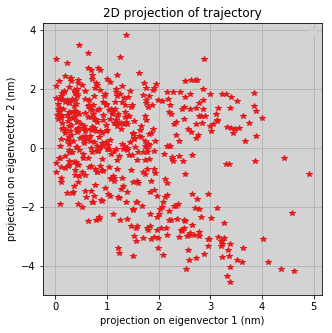

In [34]:
metadata, data = xvg.parse_xvg('big_data/2d_pca12.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')

In [35]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -first 2 -last 3 -2d big_data/2d_pca23.xvg<<!
7
7
!

No handles with labels found to put in legend.


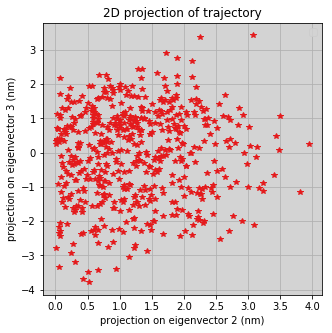

In [36]:
metadata, data = xvg.parse_xvg('big_data/2d_pca23.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')

In [37]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -first 3 -last 4 -2d big_data/2d_pca34.xvg<<!
7
7
!

No handles with labels found to put in legend.


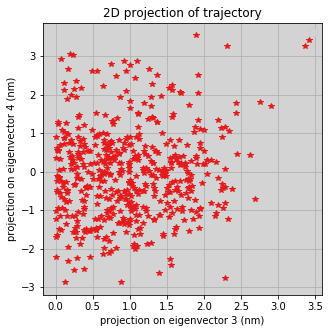

In [38]:
metadata, data = xvg.parse_xvg('big_data/2d_pca34.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')

In [39]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -first 4 -last 5 -2d big_data/2d_pca45.xvg<<!
7
7
!

No handles with labels found to put in legend.


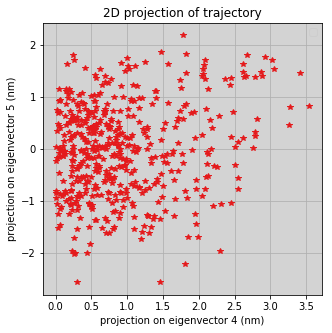

In [40]:
metadata, data = xvg.parse_xvg('big_data/2d_pca45.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')